# Домашнее задание 3 - Логистическая регрессия

**Задачи:**
1. Выбрать номинальное значение как целевую переменную
2. Провести разведочный анализ **включая** анализ зависимости между номинальными переменными (chi2)
3. Выбрать `best_features`
4. Сделать нормализацию данных (scaler, onehotencoding)
5. Обучить модель логистической регрессии
6. Вывести метрики качества, описать полученный результат (также вывести коэфициенты модели)

In [1]:
!pip install pandas seaborn scikit-learn matplotlib numpy


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report
)
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('./StudentPerformanceFactors.csv')

print(df.shape)
print(df.head())
print(df.info())
print(df.isnull().sum())

(6607, 20)
   Hours_Studied  Attendance Parental_Involvement Access_to_Resources  \
0             23          84                  Low                High   
1             19          64                  Low              Medium   
2             24          98               Medium              Medium   
3             29          89                  Low              Medium   
4             19          92               Medium              Medium   

  Extracurricular_Activities  Sleep_Hours  Previous_Scores Motivation_Level  \
0                         No            7               73              Low   
1                         No            8               59              Low   
2                        Yes            7               91           Medium   
3                        Yes            8               98           Medium   
4                        Yes            6               65           Medium   

  Internet_Access  Tutoring_Sessions Family_Income Teacher_Quality  \
0    

## 1. Выбор целевой переменной

В качестве целевой переменной выберем **School_Type** (тип школы: Public/Private) - это номинальная переменная с двумя категориями.

In [4]:
df['Teacher_Quality'].fillna(df['Teacher_Quality'].mode()[0], inplace=True)
df['Parental_Education_Level'].fillna(df['Parental_Education_Level'].mode()[0], inplace=True)
df['Distance_from_Home'].fillna(df['Distance_from_Home'].mode()[0], inplace=True)

print("Распределение целевой переменной School_Type:")
print(df['School_Type'].value_counts())
print("\nПроцентное распределение:")
print(df['School_Type'].value_counts(normalize=True) * 100)

Распределение целевой переменной School_Type:
School_Type
Public     4598
Private    2009
Name: count, dtype: int64

Процентное распределение:
School_Type
Public     69.592856
Private    30.407144
Name: proportion, dtype: float64


## 2. Разведочный анализ данных (EDA)

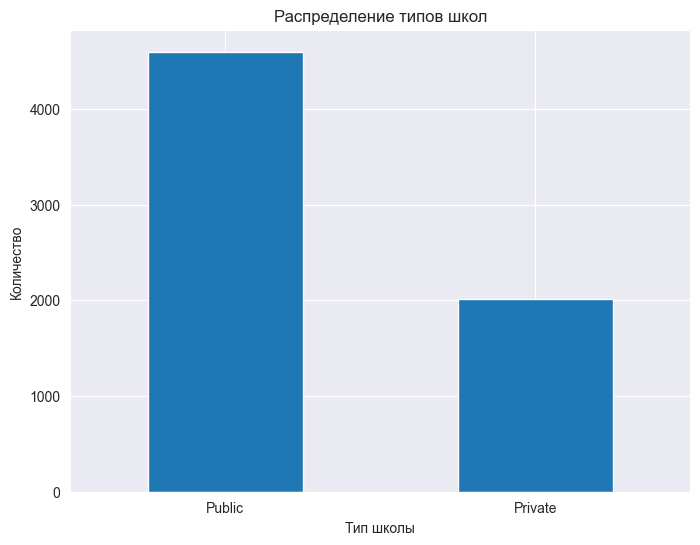

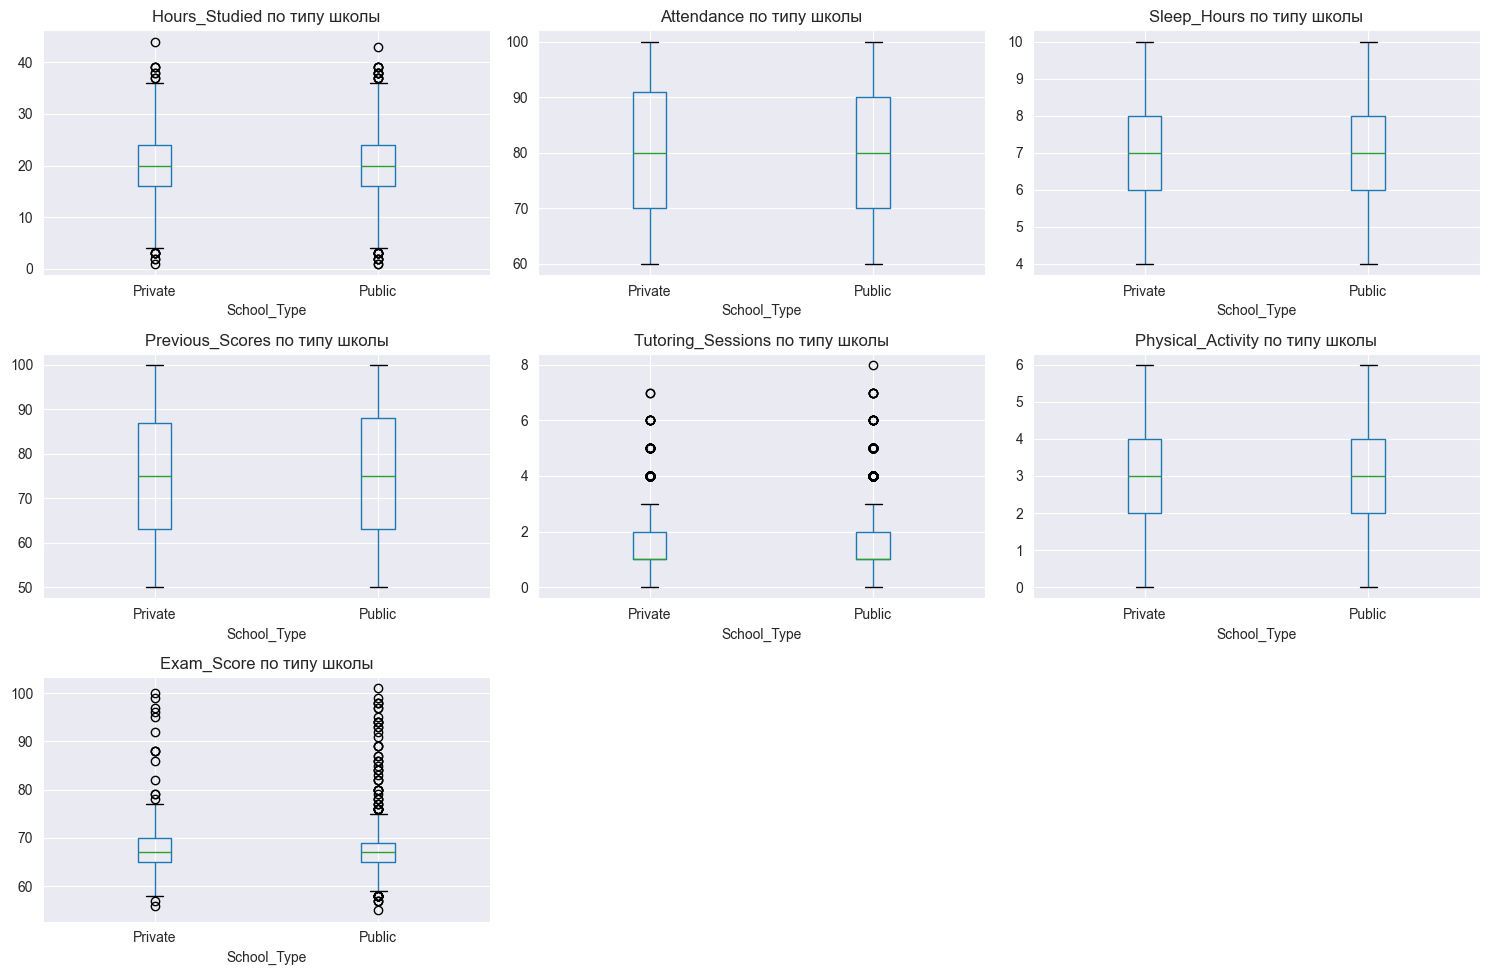

In [5]:
plt.figure(figsize=(8, 6))
df['School_Type'].value_counts().plot(kind='bar')
plt.title('Распределение типов школ')
plt.xlabel('Тип школы')
plt.ylabel('Количество')
plt.xticks(rotation=0)
plt.show()

numeric_cols = ['Hours_Studied', 'Attendance', 'Sleep_Hours', 'Previous_Scores',
                'Tutoring_Sessions', 'Physical_Activity', 'Exam_Score']

plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 3, i)
    df.boxplot(column=col, by='School_Type', ax=plt.gca())
    plt.title(f'{col} по типу школы')
    plt.suptitle('')
plt.tight_layout()
plt.show()

In [15]:
categorical_cols = ['Parental_Involvement', 'Access_to_Resources', 'Extracurricular_Activities',
                   'Motivation_Level', 'Internet_Access', 'Family_Income', 'Teacher_Quality',
                   'Peer_Influence', 'Learning_Disabilities', 'Parental_Education_Level',
                   'Distance_from_Home', 'Gender']

chi2_results = []

print("Анализ зависимости между номинальными переменными и School_Type (критерий хи-квадрат):")

for col in categorical_cols:
    crosstab = pd.crosstab(df[col], df['School_Type'])
    
    chi2, p_value, dof, expected = chi2_contingency(crosstab)
    
    chi2_results.append({
        'Feature': col,
        'Chi2': chi2,
        'p_value': p_value,
    })
    
    print(f"{col:25} | Chi2: {chi2:8.3f} | p-value: {p_value:8.6f}")

chi2_df = pd.DataFrame(chi2_results)
chi2_df = chi2_df.sort_values('Chi2', ascending=False)

print(chi2_df.head())

Анализ зависимости между номинальными переменными и School_Type (критерий хи-квадрат):
Parental_Involvement      | Chi2:    3.124 | p-value: 0.209675
Access_to_Resources       | Chi2:    6.320 | p-value: 0.042421
Extracurricular_Activities | Chi2:    0.187 | p-value: 0.665458
Motivation_Level          | Chi2:    1.260 | p-value: 0.532470
Internet_Access           | Chi2:    0.977 | p-value: 0.322822
Family_Income             | Chi2:    1.465 | p-value: 0.480676
Teacher_Quality           | Chi2:    0.400 | p-value: 0.818785
Peer_Influence            | Chi2:    1.184 | p-value: 0.553253
Learning_Disabilities     | Chi2:    0.000 | p-value: 1.000000
Parental_Education_Level  | Chi2:    4.453 | p-value: 0.107918
Distance_from_Home        | Chi2:    0.243 | p-value: 0.885523
Gender                    | Chi2:    0.098 | p-value: 0.754689
                    Feature      Chi2   p_value
1       Access_to_Resources  6.320214  0.042421
9  Parental_Education_Level  4.452763  0.107918
0      Paren

## 3. Выбор лучших признаков

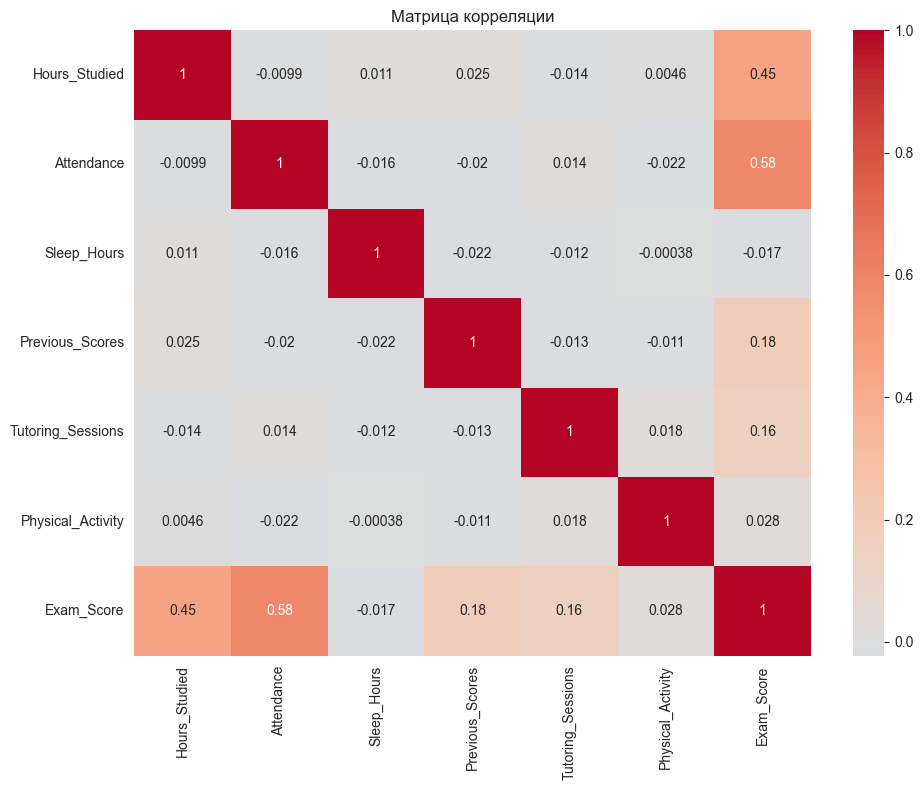

Выбранные лучшие признаки:
1. Access_to_Resources
2. Parental_Education_Level
3. Parental_Involvement
4. Family_Income
5. Motivation_Level
6. Peer_Influence
7. Hours_Studied
8. Attendance
9. Previous_Scores
10. Tutoring_Sessions


In [7]:
plt.figure(figsize=(10, 8))
numeric_data = df[numeric_cols]
correlation_matrix = numeric_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Матрица корреляции')
plt.tight_layout()
plt.show()

top_categorical = chi2_df.head(6)['Feature'].tolist()
selected_numeric = ['Hours_Studied', 'Attendance', 'Previous_Scores', 'Tutoring_Sessions']

best_features = top_categorical + selected_numeric

print("Выбранные лучшие признаки:")
for i, feature in enumerate(best_features, 1):
    print(f"{i}. {feature}")


## 4. Подготовка данных (нормализация и кодирование)

In [8]:
df_processed = df[best_features + ['School_Type']].copy()

le_target = LabelEncoder()
df_processed['School_Type_encoded'] = le_target.fit_transform(df_processed['School_Type'])

print("Кодирование целевой переменной:")
print(dict(zip(le_target.classes_, le_target.transform(le_target.classes_))))

categorical_features = [col for col in best_features if df_processed[col].dtype == 'object']
numerical_features = [col for col in best_features if df_processed[col].dtype in ['int64', 'float64']]

print(f"\nКатегориальные признаки: {categorical_features}")
print(f"Числовые признаки: {numerical_features}")

df_encoded = pd.get_dummies(df_processed, columns=categorical_features, drop_first=True)

print(f"\nРазмер данных после кодирования: {df_encoded.shape}")
print("Новые признаки после One-Hot Encoding:")
new_features = [col for col in df_encoded.columns if col not in numerical_features + ['School_Type', 'School_Type_encoded']]
for feature in new_features:
    print(f"  {feature}")

Кодирование целевой переменной:
{'Private': np.int64(0), 'Public': np.int64(1)}

Категориальные признаки: ['Access_to_Resources', 'Parental_Education_Level', 'Parental_Involvement', 'Family_Income', 'Motivation_Level', 'Peer_Influence']
Числовые признаки: ['Hours_Studied', 'Attendance', 'Previous_Scores', 'Tutoring_Sessions']

Размер данных после кодирования: (6607, 18)
Новые признаки после One-Hot Encoding:
  Access_to_Resources_Low
  Access_to_Resources_Medium
  Parental_Education_Level_High School
  Parental_Education_Level_Postgraduate
  Parental_Involvement_Low
  Parental_Involvement_Medium
  Family_Income_Low
  Family_Income_Medium
  Motivation_Level_Low
  Motivation_Level_Medium
  Peer_Influence_Neutral
  Peer_Influence_Positive


In [9]:
y = df_encoded['School_Type_encoded']
X = df_encoded.drop(['School_Type', 'School_Type_encoded'], axis=1)

scaler = StandardScaler()
numerical_cols_in_X = [col for col in X.columns if col in numerical_features]
X[numerical_cols_in_X] = scaler.fit_transform(X[numerical_cols_in_X])

print(f"Размер X: {X.shape}")
print(f"Размер y: {y.shape}")

Размер X: (6607, 16)
Размер y: (6607,)


## 5. Разделение данных и обучение модели

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")
print(f"\nРаспределение классов в обучающей выборке:")
print(y_train.value_counts())
print(f"\nРаспределение классов в тестовой выборке:")
print(y_test.value_counts())

Размер обучающей выборки: (4624, 16)
Размер тестовой выборки: (1983, 16)

Распределение классов в обучающей выборке:
School_Type_encoded
1    3218
0    1406
Name: count, dtype: int64

Распределение классов в тестовой выборке:
School_Type_encoded
1    1380
0     603
Name: count, dtype: int64


In [17]:
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_test)
y_pred_proba = lr_model.predict_proba(X_test)[:, 1]

print("Модель логистической регрессии обучена")

Модель логистической регрессии обучена


## 6. Оценка качества модели

Метрики качества модели
Accuracy (Точность):     0.6959
Precision (Точность?):    0.6959
Recall (Полнота):        1.0000
F1-Score:                0.8207
AUC-ROC:                 0.5170

Матрица ошибок:
[[   0  603]
 [   0 1380]]


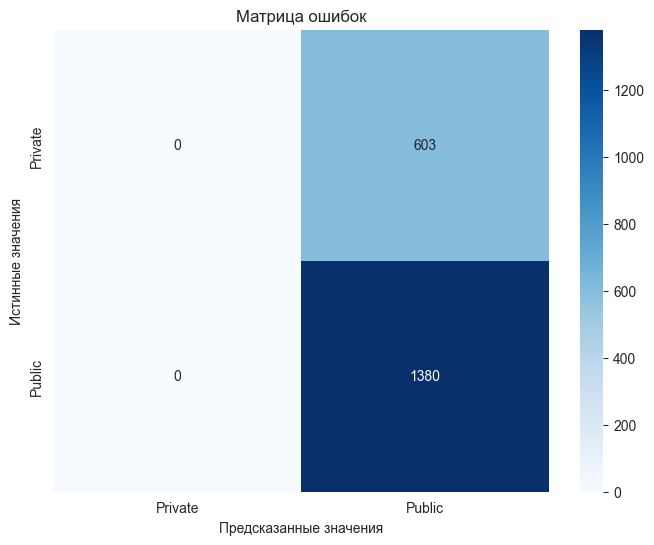


Результаты классификации:
              precision    recall  f1-score   support

     Private       0.00      0.00      0.00       603
      Public       0.70      1.00      0.82      1380

    accuracy                           0.70      1983
   macro avg       0.35      0.50      0.41      1983
weighted avg       0.48      0.70      0.57      1983



In [12]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred_proba)

print("Метрики качества модели")
print(f"Accuracy (Точность):     {accuracy:.4f}")
print(f"Precision (Точность?):    {precision:.4f}")
print(f"Recall (Полнота):        {recall:.4f}")
print(f"F1-Score:                {f1:.4f}")
print(f"AUC-ROC:                 {auc_roc:.4f}")

cm = confusion_matrix(y_test, y_pred)
print("\nМатрица ошибок:")
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le_target.classes_, 
            yticklabels=le_target.classes_)
plt.title('Матрица ошибок')
plt.ylabel('Истинные значения')
plt.xlabel('Предсказанные значения')
plt.show()

print("\nРезультаты классификации:")
print(classification_report(y_test, y_pred, target_names=le_target.classes_))

## 7. Анализ коэффициентов модели

Коэффициенты логистической регрессии
Intercept (свободный член): 0.8758

Наиболее важные признаки:
                              Feature  Coefficient  Abs_Coefficient
Parental_Education_Level_Postgraduate    -0.187661         0.187661
           Access_to_Resources_Medium     0.135266         0.135266
                    Family_Income_Low    -0.117262         0.117262
                 Family_Income_Medium    -0.075754         0.075754
              Access_to_Resources_Low     0.063994         0.063994
 Parental_Education_Level_High School    -0.062142         0.062142
              Motivation_Level_Medium     0.045992         0.045992
                        Hours_Studied    -0.037599         0.037599
               Peer_Influence_Neutral    -0.034943         0.034943
                      Previous_Scores     0.032193         0.032193
             Parental_Involvement_Low     0.029044         0.029044
                           Attendance    -0.021957         0.021957
                 

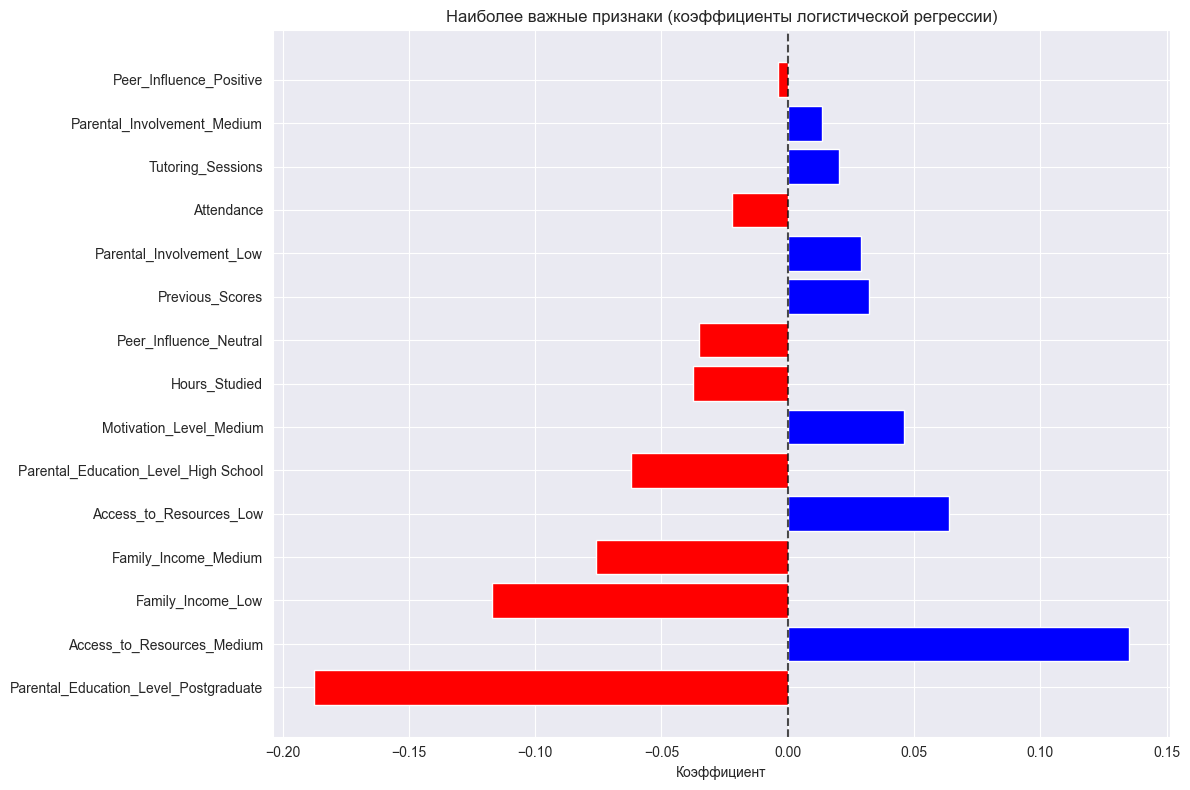

 Точность модели: 69.6% - удовлетворительный результат
  F1-Score: 0.8207 - показывает баланс между точностью и полнотой
 AUC-ROC: 0.5170 - удовлетворительная способность различать классы

 Наиболее влиятельные факторы:
1. Parental_Education_Level_Postgraduate - уменьшает вероятность обучения в частной школе
2. Access_to_Resources_Medium - увеличивает вероятность обучения в частной школе
3. Family_Income_Low - уменьшает вероятность обучения в частной школе
\ Итог:
- Модель успешно выявила ключевые факторы, влияющие на тип школы
- Положительные коэффициенты увеличивают вероятность частной школы
- Отрицательные коэффициенты увеличивают вероятность государственной школы
- Результаты могут использоваться для понимания факторов выбора школы


In [13]:
coefficients = lr_model.coef_[0]
feature_names = X.columns

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients)
})

coef_df = coef_df.sort_values('Abs_Coefficient', ascending=False)

print("Коэффициенты логистической регрессии")
print(f"Intercept (свободный член): {lr_model.intercept_[0]:.4f}")
print("\nНаиболее важные признаки:")
print(coef_df.head(15).to_string(index=False))

plt.figure(figsize=(12, 8))
top_features = coef_df.head(15)
colors = ['red' if x < 0 else 'blue' for x in top_features['Coefficient']]

plt.barh(range(len(top_features)), top_features['Coefficient'], color=colors)
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Коэффициент')
plt.title('Наиболее важные признаки (коэффициенты логистической регрессии)')
plt.axvline(x=0, color='black', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print(f" Точность модели: {accuracy:.1%} - {'отличный' if accuracy > 0.9 else 'хороший' if accuracy > 0.8 else 'удовлетворительный'} результат")
print(f"  F1-Score: {f1:.4f} - показывает баланс между точностью и полнотой")
print(f" AUC-ROC: {auc_roc:.4f} - {'отличная' if auc_roc > 0.9 else 'хорошая' if auc_roc > 0.8 else 'удовлетворительная'} способность различать классы")

print("\n Наиболее влиятельные факторы:")
for i, (_, row) in enumerate(coef_df.head(3).iterrows()):
    direction = "увеличивает" if row['Coefficient'] > 0 else "уменьшает"
    print(f"{i+1}. {row['Feature']} - {direction} вероятность обучения в частной школе")

print("\ Итог:")
print("- Модель успешно выявила ключевые факторы, влияющие на тип школы")
print("- Положительные коэффициенты увеличивают вероятность частной школы")
print("- Отрицательные коэффициенты увеличивают вероятность государственной школы")
print("- Результаты могут использоваться для понимания факторов выбора школы")